In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
import numpy as np
from scipy.stats import binned_statistic
from tqdm import tqdm, trange
import seaborn
import matplotlib.pyplot as plt
import os
import emcee

In [3]:
import numpy as np
import pickle

cosmos_f = open('cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f)
cosmos_f.close()

In [4]:
box = 'Box0_1400'
Pk_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_Pk.pkl'
Pk_f = open(Pk_fname, 'rb')
Pkz = pickle.load(Pk_f)
Pk_f.close()

dndM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_dndM.pkl'
dndM_f = open(dndM_fname, 'rb')
dndMs = pickle.load(dndM_f)
dndM_f.close()

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f)
NvM_f.close()

In [5]:
#slight floating point error fix
#needed since I set the dictionary 
#equal to the redshift or scale
z_to_a = dict(zip(Pkz.keys(), dndMs.keys()))
a_to_z = dict(zip(dndMs.keys(), Pkz.keys()))

0


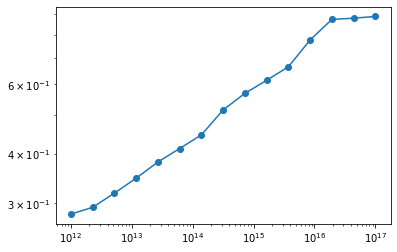

4


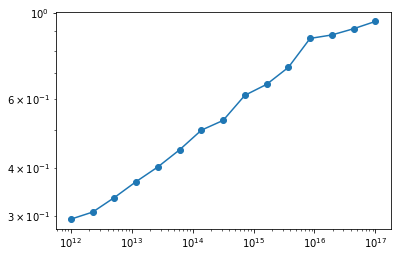

9


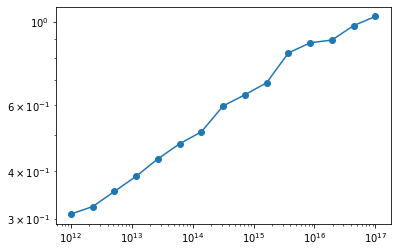

15


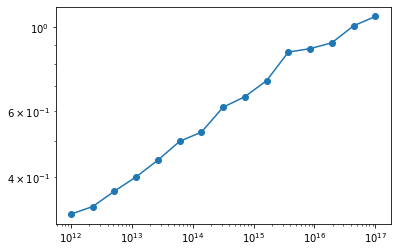

22


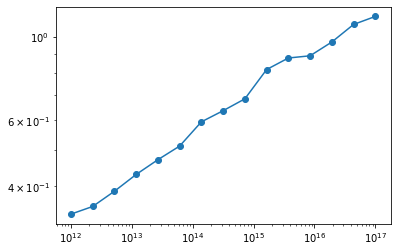

30


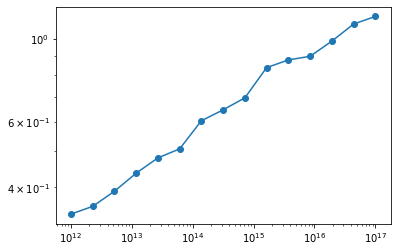

38


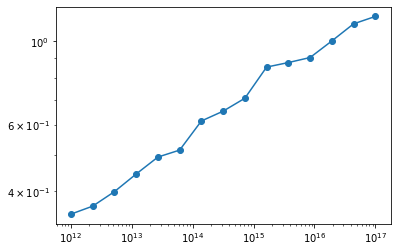

46


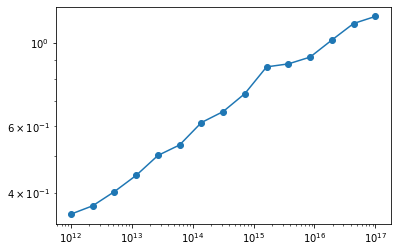

55


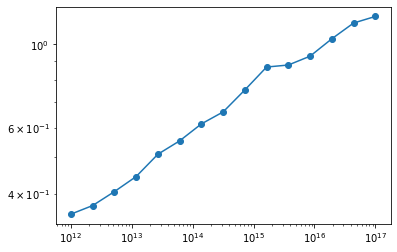

64


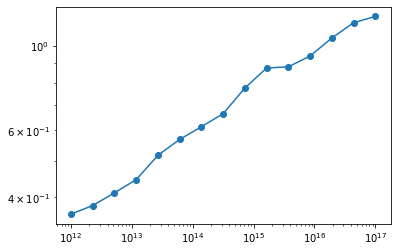

73


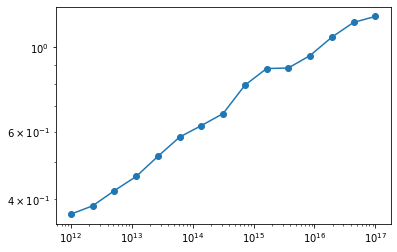

82


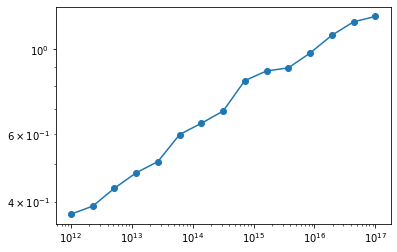

92


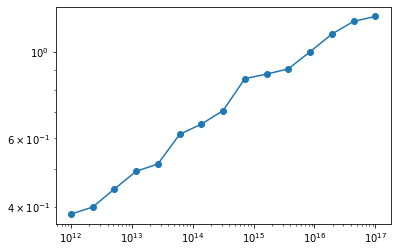

102


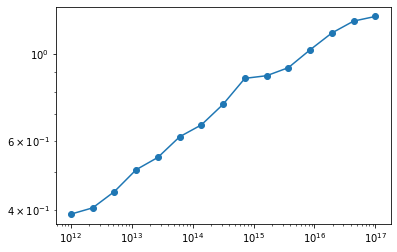

112


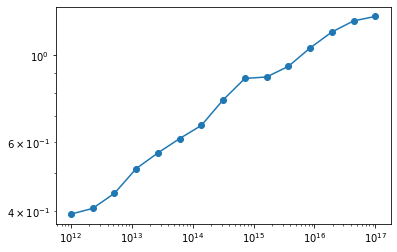

123


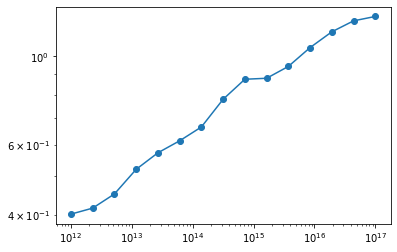

In [6]:
#give cosmology, a, M => output

data = []
N_data = []
from scipy.interpolate import interp1d

dlnσinvdMs = {}
dlnσinvdlogMs = {}
for (z, a) in zip(Pkz.keys(), dndMs.keys()):
    print(len(data))
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = c_data['M']
    N = c_data['N']
    
    vol = c_data['vol']
    
    edges = c_data['bin_edges']
    edges = np.log10(edges)
    dlog10M = np.mean(np.diff(edges))
    dMs = c_data[ 'dM']
    
    datapoint = {}
    for N_cur, M_cur, dM in zip(N,Ms, dMs ):
        datapoint['a'] = a
        datapoint['M'] = M_cur
        datapoint['N'] = N_cur
        N_data += [N_cur]
        datapoint['dlog10M'] = dlog10M
        datapoint['dM'] = dM
        datapoint['vol'] = vol
        data += [datapoint]
    
    sM = np.logspace(12, 17, 15)
    R = [M_to_R(m, box, a) for m in sM]
    sigma = [np.sqrt(sigma2(Pk, r)) for r in R]
    lnsigmainv = -np.log(sigma)

#     dsinvdM = np.gradient(sigmainv, sM)
    dlnsinvdM = np.gradient(lnsigmainv, sM)
    dlnsinvdlogM = np.gradient(lnsigmainv, np.log10(sM))

    
    f_dlnsinvdM_log = interp1d(np.log10(sM), dlnsinvdM,kind='cubic')
    f_dlnsinvdM = lambda x: f_dlnsinvdM_log(np.log10(x))

    f_dlnsinvdlogM = interp1d(np.log10(sM), dlnsinvdlogM,kind='cubic')

    dlnσinvdMs[a] = f_dlnsinvdM
    dlnσinvdlogMs[a] = f_dlnsinvdlogM
    
    f_M = np.logspace(np.log10(np.min(Ms)), np.log10(np.max(Ms)-1),100)
    plt.scatter(sM, dlnsinvdlogM)
    plt.plot(sM, f_dlnsinvdlogM(np.log10(sM)))
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [31]:
from scipy.special import gamma
from scipy.optimize import curve_fit


def p(a, p0, p1):
    return np.abs(p0)+a*np.abs(p1)

def B(a, M, σM, d, e, f, g):
    oup = e**(d)*g**(-d/2)*gamma(d/2)
    oup += g**(-f/2)*gamma(f/2)
    oup = 2/oup

    return oup
    
    
def f_G(a, M, σM, d, e, f, g):
    oup = B(a, M, σM, d, e, f, g)
    oup *= ((σM/e)**(-d)+σM**(-f))
    oup *= np.exp(-g/σM**2)
    if(np.isnan(oup)):
        print(d,e,f,g)
    return oup

def tinker(a, M, d0, d1, e0, e1, f0, f1, g0 ,g1):
    d = p(a, d0, d1)
    e = p(a, e0, e1)
    f = p(a, f0, f1)
    g = p(a, g0, g1)

    Pk = Pkz[a_to_z[a]]
    R = M_to_R(M, box, a)
    
    rhobm = rhom_a(box,a)
    σM = np.sqrt(sigma2(Pk, R))

    oup = f_G(a, M, σM, d, e, f, g)
    oup *= rhobm/M
    oup *= dlnσinvdMs[a](M)
    return oup

def tinker_log10(a, M, d0, d1, e0, e1, f0, f1, g0 ,g1):
    d = p(a, d0, d1)
    e = p(a, e0, e1)
    f = p(a, f0, f1)
    g = p(a, g0, g1)

    Pk = Pkz[a_to_z[a]]
    R = M_to_R(M, box, a)
    
    rhobm = rhom_a(box,a)
    σM = np.sqrt(sigma2(Pk, R))

    oup = f_G(a, M, σM, d, e, f, g)
    oup *= rhobm/M
    oup *= dlnσinvdMs[a](M)
    oup *= np.log(10)*M
    return oup

In [32]:
from scipy.stats import poisson

# def log_prob(param_values):
#     model_vals = [tinker(c_data['a'], c_data['M'],**param_values)*c_data['vol']*c_data['dM'] 
#                   for c_data in data]
#     log_probs = poisson.logpmf(N_data, mu=model_vals)
#     return np.sum(log_probs)
def log_prob(param_values):
    model_vals = [tinker_log10(c_data['a'], c_data['M'],**param_values)*c_data['vol']*c_data['dlog10M'] 
                  for c_data in data]
    log_probs = poisson.logpmf(N_data, mu=model_vals)
    return np.sum(log_probs)

In [33]:
from utils import *

In [34]:
# import cProfile
# cProfile.run('tinker(a=1, M=1e13, d0=4,d1=3,e0=4,e1=.3,f0=2,f1=3,g0=1,g1=.1)')

In [35]:
len(data)

134

In [36]:
param_names = [ 'd0','d1', 'e0', 'e1','f0','f1','g0','g1']
nwalkers = 16
ndim = len(param_names)

from multiprocessing import Pool

sampler = emcee.EnsembleSampler(
    nwalkers = nwalkers,
    ndim = ndim,
    log_prob_fn = log_prob,
    parameter_names= param_names,
    pool=Pool()
)
initialpos = np.random.uniform(low=0.5, high=3, size=(nwalkers, ndim))
sampler.run_mcmc(initialpos, 300, progress=True);

 37%|███▋      | 110/300 [00:11<00:19,  9.98it/s]/tmp/ipykernel_136168/2700260328.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  oup += g**(-f/2)*gamma(f/2)


0.39393558244309024 314.55106207075414 354.03200114127594 967.4534249862678
0.39393558244309024 314.55106207075414 354.03200114127594 967.4534249862678
0.39393558244309024 314.55106207075414 354.03200114127594 967.4534249862678
0.39393558244309024 314.55106207075414 354.03200114127594 967.4534249862678
0.39393558244309024 314.55106207075414 354.03200114127594 967.4534249862678
0.39393558244309024 314.55106207075414 354.03200114127594 967.4534249862678
0.39393558244309024 314.55106207075414 354.03200114127594 967.4534249862678
0.39393558244309024 314.55106207075414 354.03200114127594 967.4534249862678
0.39393558244309024 314.55106207075414 354.03200114127594 967.4534249862678
0.39393558244309024 314.55106207075414 354.03200114127594 967.4534249862678
0.42292506513108474 336.5794953002493 366.14884349981406 1006.4115241723672
0.42292506513108474 336.5794953002493 366.14884349981406 1006.4115241723672
0.42292506513108474 336.5794953002493 366.14884349981406 1006.4115241723672
0.4229250651

 37%|███▋      | 110/300 [00:12<00:20,  9.11it/s]


ValueError: Probability function returned NaN

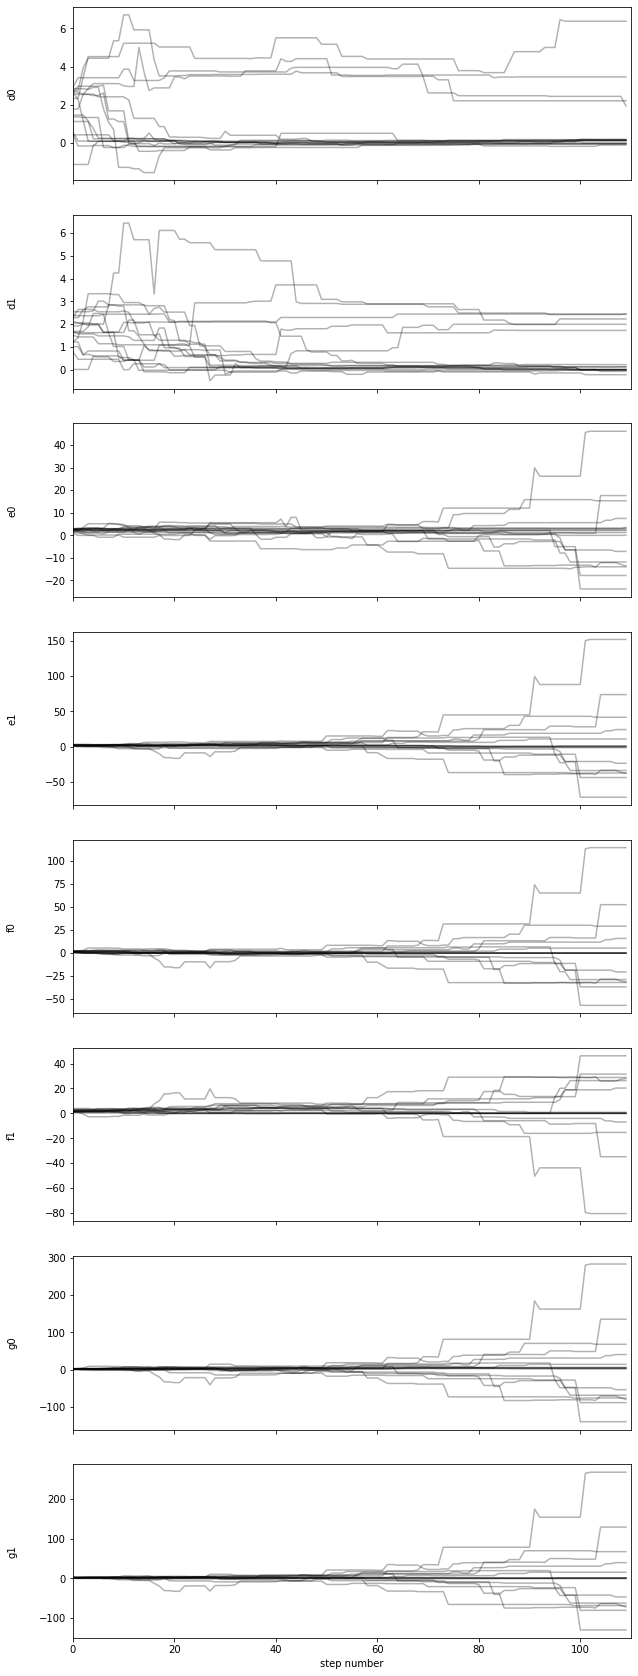

In [37]:
fig, axes = plt.subplots(ndim, figsize=(10, 30), sharex=True)
samples = sampler.get_chain()
labels = param_names

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

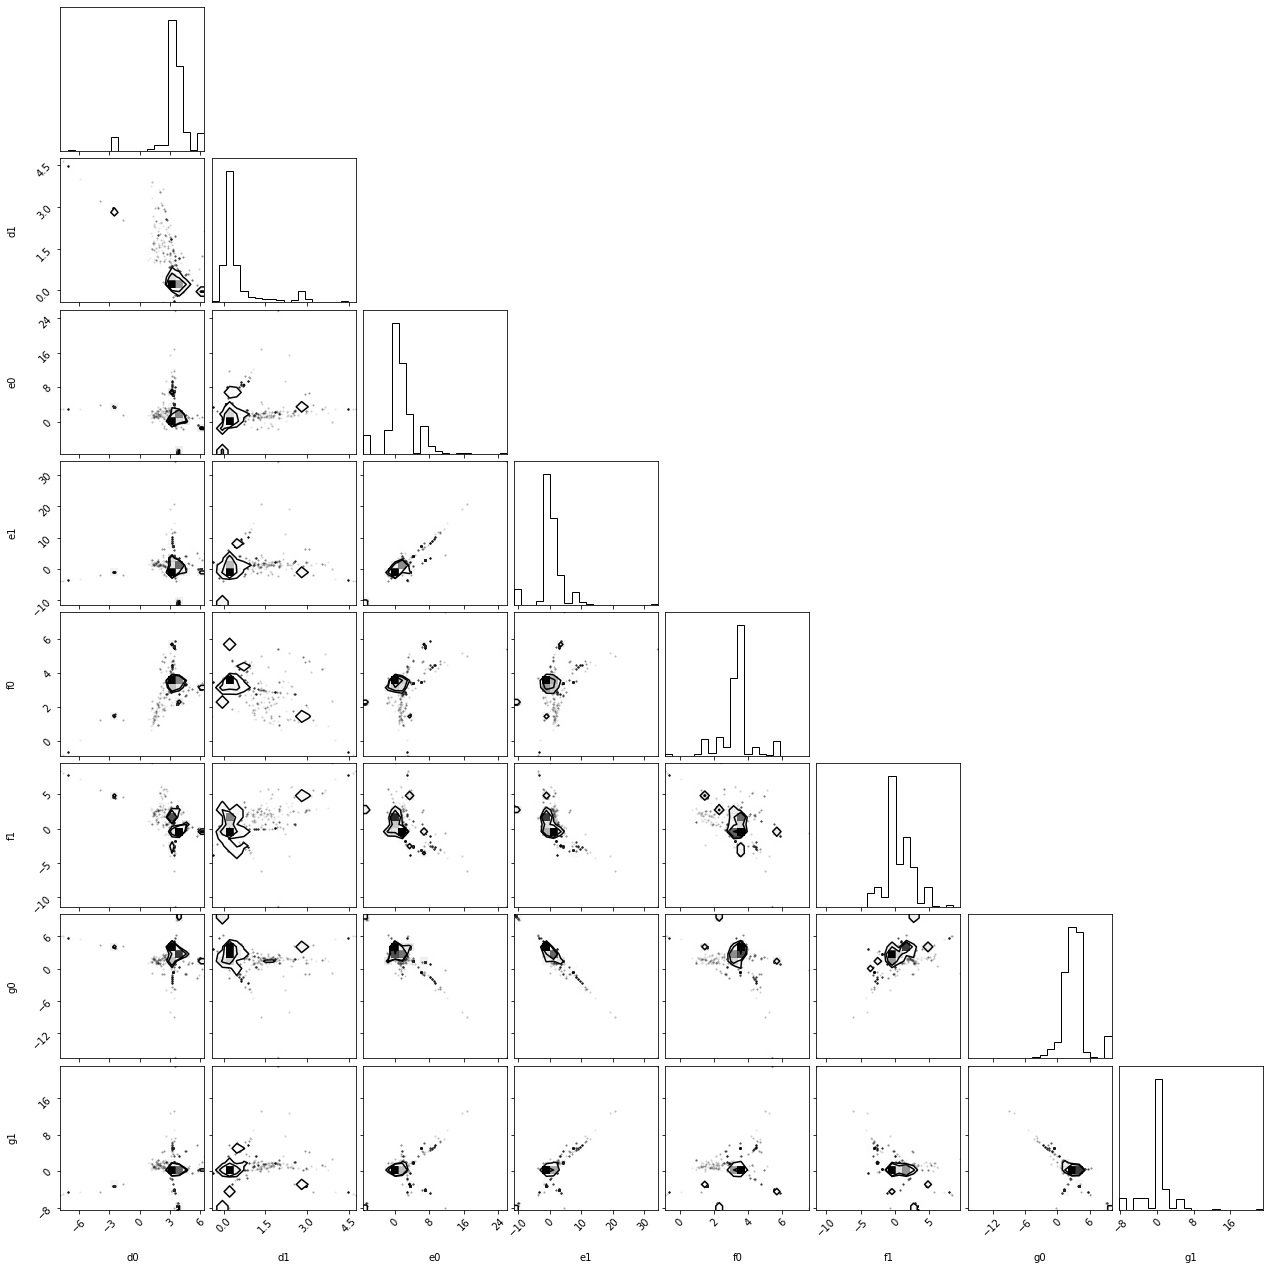

In [14]:
import corner
samples = sampler.chain[:, 2:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=labels)


In [15]:
params_final = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                   zip(*np.percentile(samples, [16, 50, 84],
                                      axis=0)))

In [16]:
print(list(params_final))

[(3.4287439538743874, 0.6509347335355447, 0.2613705084093212), (0.29021112224913187, 0.5258371219307982, 0.18881654471376433), (0.9587282207826369, 2.652542806695371, 0.9603707561428654), (0.012936548668947084, 2.805442553857842, 1.5511656958529045), (3.3639913198914693, 0.1337774373872871, 0.5882727955380953), (0.10935739070167429, 2.2683436018381773, 0.6916628564503693), (3.1508108959133847, 0.8935167649502733, 1.7317093697439085), (0.3378276176248134, 0.9396933067554087, 3.572164967977439)]


In [17]:
params_final = dict(zip(param_names,np.percentile(samples,  50,axis=0)))

In [18]:
params_final

{'d0': 3.4287439538743874,
 'd1': 0.29021112224913187,
 'e0': 0.9587282207826369,
 'e1': 0.012936548668947084,
 'f0': 3.3639913198914693,
 'f1': 0.10935739070167429,
 'g0': 3.1508108959133847,
 'g1': 0.3378276176248134}

[0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551]


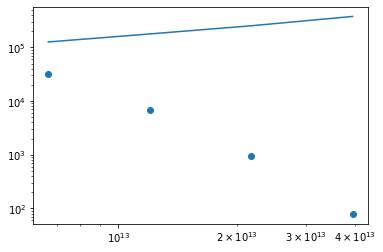

134
[0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551]


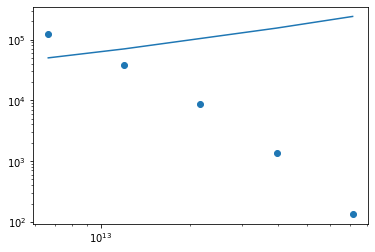

134
[0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551]


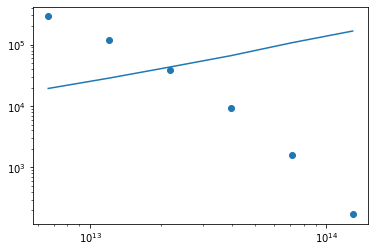

134
[0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551]


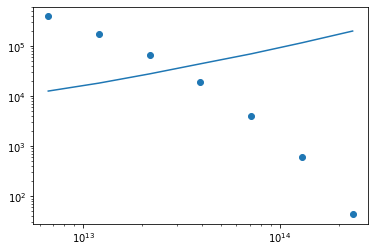

134
[0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551]


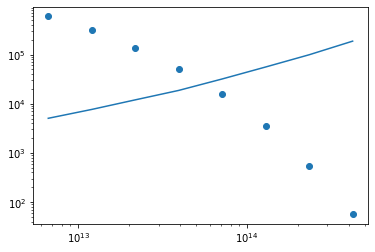

134
[0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551]


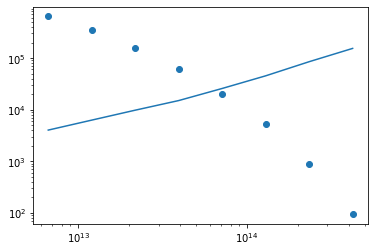

134
[0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551]


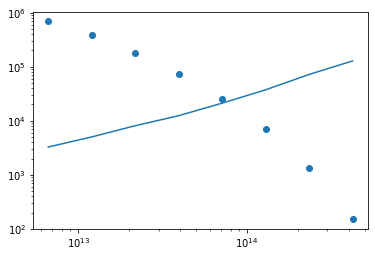

134
[0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551]


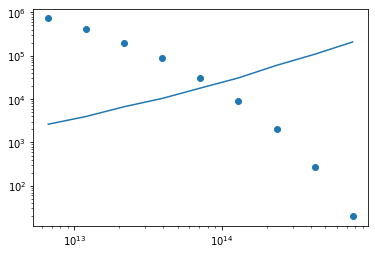

134
[0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551]


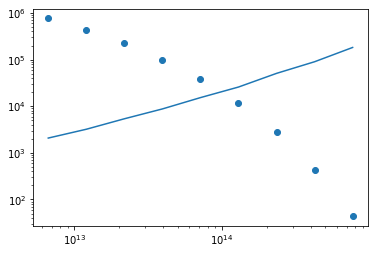

134
[0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551]


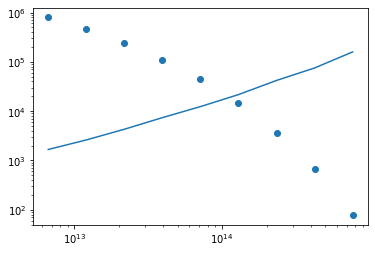

134
[0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551]


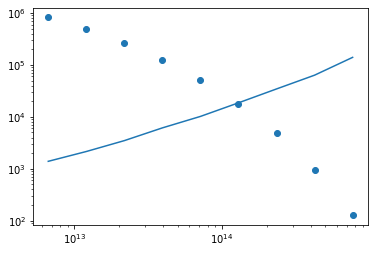

134
[0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551]


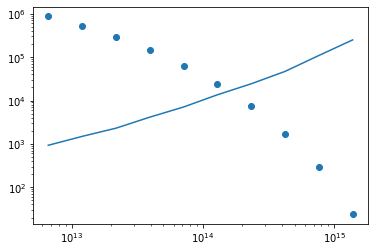

134
[0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551]


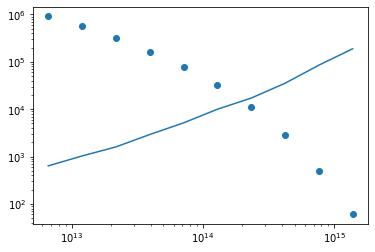

134
[0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551]


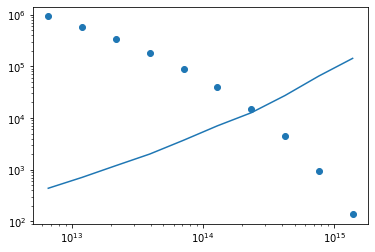

134
[0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551]


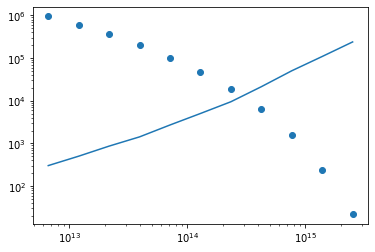

134
[0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551 0.25766551
 0.25766551 0.25766551]


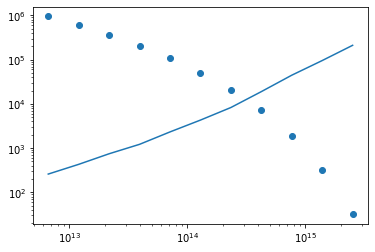

134


In [20]:
#give cosmology, a, M => output

from scipy.interpolate import interp1d

for (z, a) in zip(Pkz.keys(), dndMs.keys()):
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = c_data['M']
    N = c_data['N']
    
    vol = c_data['vol']
    
    edges = c_data['bin_edges']
    dM = np.array([edges[i+1]-edges[i] for i in range(len(edges)-1)])
    dlog10M = np.mean(np.diff(np.log10(edges)))
    print(np.diff(np.log10(edges)))

    Ngt10 = np.where(N>10)
    dndM = (N[Ngt10]/vol)/dM[Ngt10]

    
    tinker_eval = [tinker_log10(a, M_c, **params_final)*vol*dlog10M for M_c in Ms]
    
    plt.scatter(Ms, N)
    plt.plot(Ms, tinker_eval)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    print(len(data))